In [3]:
%matplotlib widget
import obspy
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta, aic_simple
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import coincidence_trigger
from obspy.signal.cross_correlation import correlation_detector
from obspy.signal import PPSD
from obspy import read_inventory
from obspy.realtime.signal import kurtosis
from obspy.signal import filter



from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import obspy.signal.trigger as trigger
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plot_working
import event_processing
import loading_stream_function

import matplotlib.ticker as ticker
from datetime import datetime
from datetime import timedelta

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
chan = 'GHZ'
#statlist = [ 'A01' ,'A03' , 'A05' , 'A07' , 'A09' , 'A11' , 'A13' , 'A15' , 'A17' , 'A19' ]
statlist = [ 'A01' ,'A02' , 'A03' , 'A04' , 'A05' , 'A06' , 'A07' , 'A08' , 'A09', 'A10' , 'A11', 'A13', 'A14', 'A19']#, 'A16', 'A17', 'A18', 'A19' ]
#statlist = [ 'B01' ,'B02' , 'B03' , 'B04' , 'B06' , 'B07' , 'B08' , 'B09','B10' , 'B11', 'B12', 'B13' , 'B19' , 'B20']#,'B14','B15','B16','B17','B18','B19', 'B20' ]

day = 15
stream = obspy.read("/media/sbrent/Oman3/PASSCAL/Main_deployment/DAYS/" +statlist[0]+ "/*.." + chan +".2020.0" +str(day))


In [6]:
for s in statlist[1:]:
    
    stream += obspy.read("/media/sbrent/Oman3/PASSCAL/Main_deployment/DAYS/" + s + "/*.." + chan + ".2020.0" + str(day))


In [7]:
hr = 15
start_time = obspy.UTCDateTime('2020-1-' + str(day) + 'T00:00:00')+hr*3600
end_time = obspy.UTCDateTime('2020-1-' + str(day) + 'T00:00:00')+(hr+1)*3600
data15 = stream.slice(starttime=start_time,endtime=end_time) #look into trim()
#print(data)
print(start_time, end_time)

2020-01-15T15:00:00.000000Z 2020-01-15T16:00:00.000000Z


In [8]:
data15_cp = data15.copy()
data15_cp2 = data15.copy()

In [9]:

stream_filt = data15.filter('highpass', corners=4, freq=80, zerophase=False)
stream_2 = stream_filt.copy()
events = coincidence_trigger("classicstalta", 5, 0.8, stream_2, 3, sta=0.02, lta=0.2)
events = pd.DataFrame(events)

#g_wind1 = event_processing.get_event_window_raw(data15_cp,TIME)

In [10]:
TIME = events.time[509]
print(TIME)
g_wind1 = event_processing.get_event_window_raw(data15_cp,TIME)
g_wind1 = g_wind1.detrend('demean')

2020-01-15T15:21:37.239000Z


In [42]:
class PrecisionDateFormatter(ticker.Formatter):
    """
    Extend the `matplotlib.ticker.Formatter` class to allow for millisecond
    precision when formatting a tick (in days since the epoch) with a
    `~datetime.datetime.strftime` format string.

    """

    def __init__(self, fmt, precision=3, tz=None):
        """
        Parameters
        ----------
        fmt : str
            `~datetime.datetime.strftime` format string.
        """
        from matplotlib.dates import num2date
        if tz is None:
            from matplotlib.dates import _get_rc_timezone
            tz = _get_rc_timezone()
        self.num2date = num2date
        self.fmt = fmt
        self.tz = tz
        self.precision = precision

    def __call__(self, x, pos=0):
        if x == 0:
            raise ValueError("DateFormatter found a value of x=0, which is "
                             "an illegal date; this usually occurs because "
                             "you have not informed the axis that it is "
                             "plotting dates, e.g., with ax.xaxis_date()")

        dt = self.num2date(x, self.tz)
        ms = dt.strftime("%f")[:self.precision]

        return dt.strftime(self.fmt).format(ms=ms)

    def set_tzinfo(self, tz):
        self.tz = tz

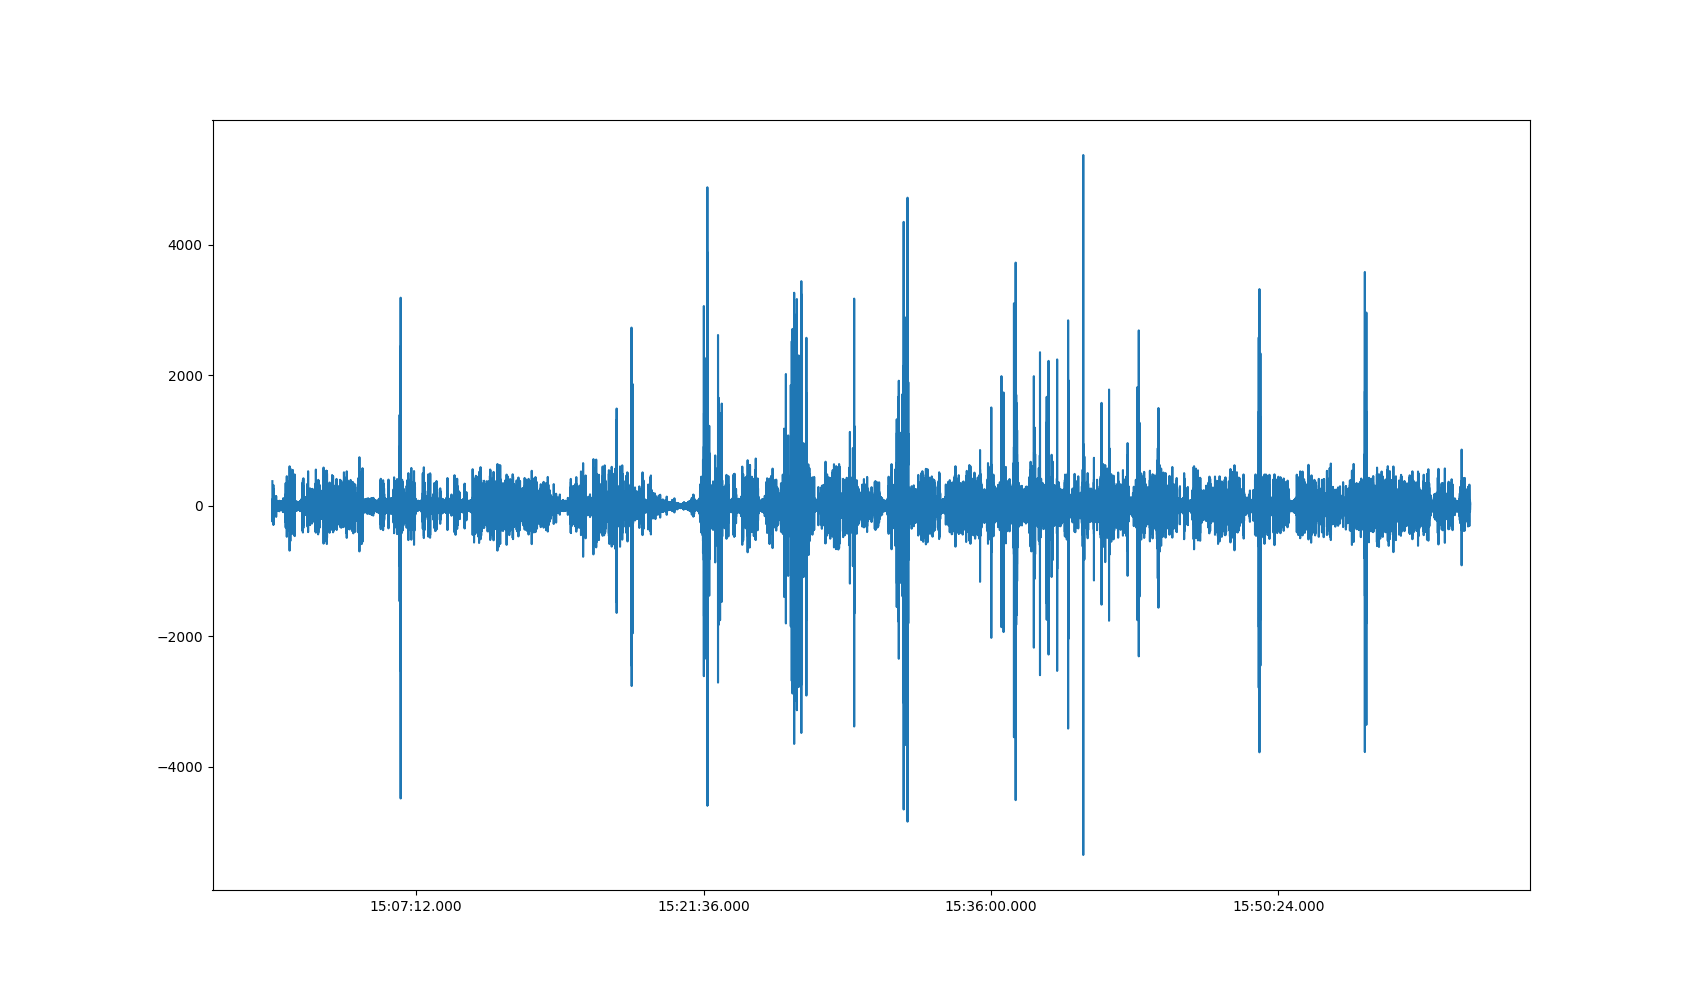

In [43]:
fig, ax = plt.subplots(1, figsize=(17, 10), sharex=True, sharey=False)
ax.plot(data15_cp2[0].times('matplotlib'), data15_cp2[0].data)
ax.xaxis.set_major_formatter(PrecisionDateFormatter("%H:%M:%S.{ms}"))

In [ ]:
#fig.clf()

In [9]:
events

,time,stations,trace_ids,coincidence_sum,similarity,duration
0,2020-01-15T15:00:02.861000Z,"[A04, A03, A06, A01, A02, A05, A10]","[7F.A04..BHZ, 7F.A03..BHZ, 7F.A06..BHZ, 7F.A01...",7.0,{},0.172
1,2020-01-15T15:00:03.380000Z,"[A04, A03, A06, A02, A01, A05]","[7F.A04..BHZ, 7F.A03..BHZ, 7F.A06..BHZ, 7F.A02...",6.0,{},0.105
2,2020-01-15T15:00:11.307000Z,"[A01, A02, A06]","[7F.A01..BHZ, 7F.A02..BHZ, 7F.A06..BHZ]",3.0,{},0.073
3,2020-01-15T15:00:39.897000Z,"[A04, A03, A02, A01, A06, A05, A10]","[7F.A04..BHZ, 7F.A03..BHZ, 7F.A02..BHZ, 7F.A01...",7.0,{},0.169
4,2020-01-15T15:00:41.145000Z,"[A04, A03, A01, A02, A06]","[7F.A04..BHZ, 7F.A03..BHZ, 7F.A01..BHZ, 7F.A02...",5.0,{},0.107
...,...,...,...,...,...,...
1716,2020-01-15T15:59:53.224000Z,"[A04, A05, A03, A06, A02, A01, A10]","[7F.A04..BHZ, 7F.A05..BHZ, 7F.A03..BHZ, 7F.A06...",7.0,{},0.165
1717,2020-01-15T15:59:53.717000Z,"[A04, A03, A01, A06, A02, A05]","[7F.A04..BHZ, 7F.A03..BHZ, 7F.A01..BHZ, 7F.A06...",6.0,{},0.101
1718,2020-01-15T15:59:56.058000Z,"[A04, A06, A01, A03, A02, A10]","[7F.A04..BHZ, 7F.A06..BHZ, 7F.A01..BHZ, 7F.A03...",6.0,{},0.135
1719,2020-01-15T15:59:56.495000Z,"[A04, A05, A03, A06, A02, A01, A10]","[7F.A04..BHZ, 7F.A05..BHZ, 7F.A03..BHZ, 7F.A06...",7.0,{},0.188


In [39]:
events.coincidence_sum[509]

6.0

In [11]:
events.time[509]

2020-01-15T15:21:37.239000Z

In [12]:

TIME1 = obspy.UTCDateTime('2020-1-' + str(day) + 'T15:20:14')
noise1 = event_processing.get_event_window_raw(data15_cp,TIME1)
#plt.figure()
#plt.plot(noise1[0].times('matplotlib'), noise1[0].data)

In [ ]:
#fig, ax = plt.subplots(1, figsize=(17, 10), sharex=True, sharey=False)
#ax.plot(noise1[0].times('matplotlib'), noise1[0].data)
#ax.xaxis.set_major_formatter(PrecisionDateFormatter("%H:%M:%S.{ms}"))

In [ ]:
fig.clf()

In [13]:

TIME2 = obspy.UTCDateTime('2020-1-' + str(day) + 'T15:20:15')
noise2 = event_processing.get_event_window_raw(data15_cp,TIME2)
#plt.figure()
#plt.plot(noise2[0].times('matplotlib'), noise2[0].data)

In [ ]:
#fig, ax = plt.subplots(1, figsize=(17, 10), sharex=True, sharey=False)
#ax.plot(noise2[0].times('matplotlib'), noise2[0].data)
#ax.xaxis.set_major_formatter(PrecisionDateFormatter("%H:%M:%S.{ms}"))

In [14]:
hr = 16
start_time1 = obspy.UTCDateTime('2020-1-' + str(day) + 'T00:00:00')+hr*3600
end_time1 = obspy.UTCDateTime('2020-1-' + str(day) + 'T00:00:00')+(hr+1)*3600
data16 = stream.slice(starttime=start_time1,endtime=end_time1) #look into trim()

In [15]:

TIME3 = obspy.UTCDateTime('2020-1-' + str(day) + 'T16:16:40')
noise3 = event_processing.get_event_window_raw(data16,TIME3)
#plt.figure()
#plt.plot(noise3[0].times('matplotlib'), noise3[0].data)

In [16]:

TIME4 = obspy.UTCDateTime('2020-1-' + str(day) + 'T16:16:45')
noise4 = event_processing.get_event_window_raw(data16,TIME4)
#plt.figure()
#plt.plot(noise4[0].times('matplotlib'), noise4[0].data)

In [17]:

TIME5 = obspy.UTCDateTime('2020-1-' + str(day) + 'T16:16:49')
noise5 = event_processing.get_event_window_raw(data16,TIME5)
#plt.figure()data_bp
#plt.plot(noise5[0].times('matplotlib'), noise5[0].data)

In [18]:

TIME6 = obspy.UTCDateTime('2020-1-' + str(day) + 'T16:16:53')
noise6 = event_processing.get_event_window_raw(data16,TIME6)
#plt.figure()
#plt.plot(noise6[0].times('matplotlib'), noise6[0].data)

In [19]:

TIME7 = obspy.UTCDateTime('2020-1-' + str(day) + 'T16:50:26')
noise7 = event_processing.get_event_window_raw(data16,TIME7)
#plt.figure()
#plt.plot(noise7[0].times('matplotlib'), noise7[0].data)

In [20]:

TIME8 = obspy.UTCDateTime('2020-1-' + str(day) + 'T16:50:31')
noise8 = event_processing.get_event_window_raw(data16,TIME8)
#plt.figure()
#plt.plot(noise8[0].times('matplotlib'), noise8[0].data)

In [21]:

TIME9 = obspy.UTCDateTime('2020-1-' + str(day) + 'T16:50:35')
noise9 = event_processing.get_event_window_raw(data16,TIME9)
#plt.figure()
#plt.plot(noise9[0].times('matplotlib'), noise9[0].data)

In [22]:

TIME10 = obspy.UTCDateTime('2020-1-' + str(day) + 'T16:02:10')
noise10 = event_processing.get_event_window_raw(data16,TIME10)
#plt.figure()
#plt.plot(noise10[0].times('matplotlib'), noise10[0].data)

In [24]:
N = len(g_wind1[0].data)
NW = 3/2
k = 8
data = g_wind1[0].data
dt=g_wind1[0].stats.delta

data_n1 = noise1[0].data
data_n2 = noise2[0].data
data_n3 = noise3[0].data
data_n4 = noise4[0].data
data_n5 = noise5[0].data
data_n6 = noise6[0].data
data_n7 = noise7[0].data
data_n8 = noise8[0].data
data_n9 = noise9[0].data
data_n10 = noise10[0].data

In [32]:
data_cp1 = g_wind1.copy()
data_cp2 = g_wind1.copy()
data_cp3 = g_wind1.copy()
data_cp4 = g_wind1.copy()
data_hp = data_cp1.filter(type='highpass', corners=4, zerophase=True, freq=20)
data_hp_cp = data_hp.copy()
data_lp = data_hp_cp.filter(type='lowpass', corners=4, zerophase=True, freq=200)

data_hp350 = data_cp1.filter(type='highpass', corners=4, zerophase=True, freq=350)
data_hp350 = data_hp350[0].data

data_lp250 = data_cp4.filter(type='lowpass', corners=4, zerophase=True, freq=250)
data_lp250 = data_lp250[0].data


data_bp = data_cp2.filter(type="bandpass", freqmin=100, freqmax=250)  
data_bp = data_bp[0].data

#data_lp = filter.lowpass(data_hp, freq=20, zerophase=True, corners=4, df=1000)

In [35]:
len(data_bp)

14

In [36]:
len(data_hp350)

501

In [28]:
data_lp_hp = data_hp[0].data
data_lp_hp_mtm = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_lp_hp)

data_bp = data_bp[0].data
data_bp_mtm = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_bp)

In [27]:
from spectrum import *
def multi_taper(N, NW, k, dt, data):
    "This function depends on spectrum so it needs to be imported"
    [tapers, eigen] = dpss(N, NW, k)
    Sk_complex, weights, eigenvalues=pmtm(data, e=eigen, v=tapers, NFFT=N, show=False)

    Sk = abs(Sk_complex)**2
    Sk = np.mean(Sk * np.transpose(weights), axis=0) * dt
    #print(Sk[0])
    return Sk

In [29]:
mtp_n1 = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_n1)
mtp_n2 = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_n2)
mtp_n3 = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_n3)
mtp_n4 = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_n4)
mtp_n5 = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_n5)
mtp_n6 = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_n6)
mtp_n7 = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_n7)
mtp_n8 = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_n8)
mtp_n9 = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_n9)
mtp_n10 = multi_taper(N=len(g_wind1[0].data), NW=1.0, k=8, dt = g_wind1[0].stats.delta, data = data_n10)

average_noise_mtm = (mtp_n1 + mtp_n2 + mtp_n3 + mtp_n4 + mtp_n5 + mtp_n6 + mtp_n7 + mtp_n8 + mtp_n9 + mtp_n10)/10

0.01857993022622059


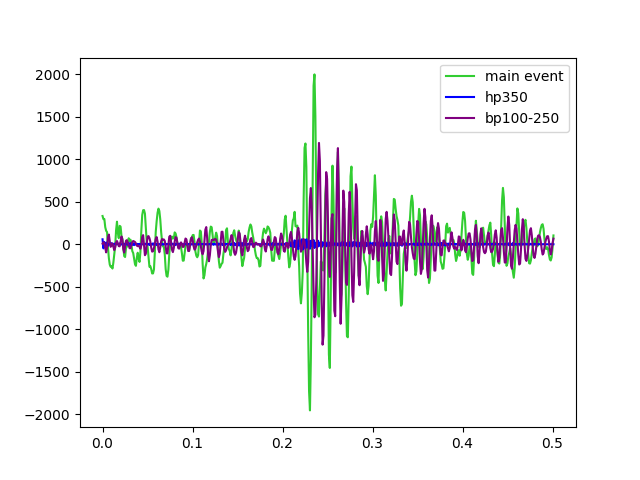

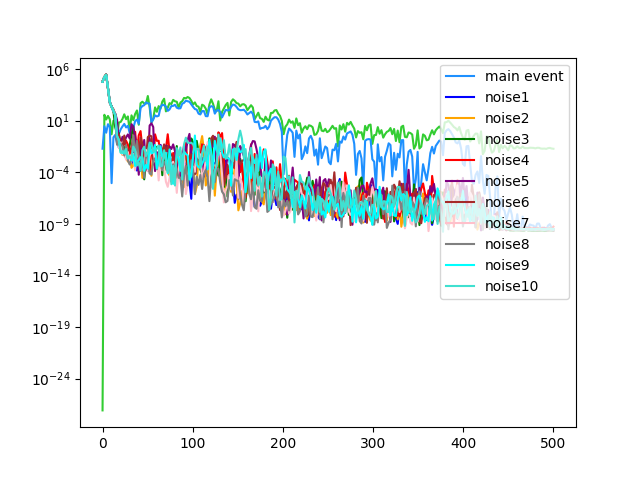

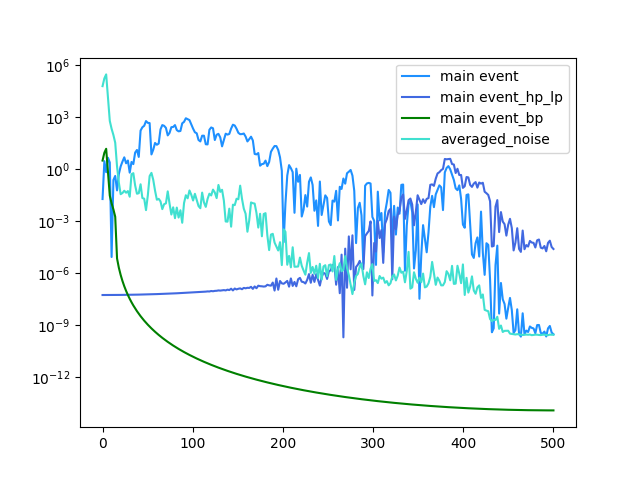

In [33]:
from spectrum import *

x = np.linspace(0.0, N*dt, N)
y = data
plt.figure()
plt.plot(x,y, 'limegreen', label = "main event")
#plt.plot(x,data_lp_hp,'green',label = "lp hp")
#plt.plot(x, data_bp, 'blue', label = "bp")
plt.plot(x, data_hp350, 'blue', label = "hp350")
plt.plot(x, data_bp, 'purple', label = "bp100-250")

plt.legend(loc="upper right")

# classical FFT
xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)
y_event = np.fft.fft(y)

#y_n1 = np.fft.fft(data_n1)
#y_n2 = np.fft.fft(data_n2)
#y_n3 = np.fft.fft(data_n3)
#y_n4 = np.fft.fft(data_n4)
#y_n5 = np.fft.fft(data_n5)
#y_n6 = np.fft.fft(data_n6)
#y_n7 = np.fft.fft(data_n7)
#y_n8 = np.fft.fft(data_n8)
#y_n9 = np.fft.fft(data_n9)
#y_n10 = np.fft.fft(data_n10)


# The multitapered method
NW=1.0
k=8
[tapers, eigen] = dpss(N, NW, k)
Sk_complex, weights, eigenvalues=pmtm(y, e=eigen, v=tapers, NFFT=N, show=False)

Sk = abs(Sk_complex)**2
Sk = np.mean(Sk * np.transpose(weights), axis=0) * dt
print(Sk[0])
# ploting both results
#plt.figure()
#plt.plot(xf,abs(y_event[0:N//2])**2 / N * dt, 'limegreen')
#plt.plot(xf,Sk[0:N//2], 'dodgerblue')

# ploting both results in log scale
plt.figure()
plt.semilogy(xf, abs(y_event[0:N // 2]) ** 2 / N * dt, 'limegreen')
plt.semilogy(xf, Sk[0:N // 2], 'dodgerblue', label = "main event")

plt.semilogy(xf, mtp_n1[0:N // 2], 'blue', label = "noise1")
plt.semilogy(xf, mtp_n2[0:N // 2], 'orange', label = "noise2")
plt.semilogy(xf, mtp_n3[0:N // 2], 'green', label = "noise3")
plt.semilogy(xf, mtp_n4[0:N // 2], 'red', label = "noise4")
plt.semilogy(xf, mtp_n5[0:N // 2], 'purple', label = "noise5")
plt.semilogy(xf, mtp_n6[0:N // 2], 'brown', label = "noise6")
plt.semilogy(xf, mtp_n7[0:N // 2], 'pink', label = "noise7")
plt.semilogy(xf, mtp_n8[0:N // 2], 'gray', label = "noise8")
plt.semilogy(xf, mtp_n9[0:N // 2], 'cyan', label = "noise9")
plt.semilogy(xf, mtp_n10[0:N // 2], 'turquoise', label = "noise10")
plt.legend(loc="upper right")




plt.figure()
#plt.semilogy(xf, abs(y_event[0:N // 2]) ** 2 / N * dt, 'limegreen')
plt.semilogy(xf, Sk[0:N // 2], 'dodgerblue', label = "main event")
plt.semilogy(xf, data_lp_hp_mtm[0:N // 2], 'royalblue', label = "main event_hp_lp")
plt.semilogy(xf, data_bp_mtm[0:N // 2], 'green', label = "main event_bp")
plt.semilogy(xf, average_noise_mtm[0:N // 2], 'turquoise', label = "averaged_noise")
plt.legend(loc="upper right")

In [ ]:
fig, ax = plt.subplots(1, figsize=(17, 10), sharex=True, sharey=False)
ax.plot(g_wind1[0].times('matplotlib'), g_wind1[0].data, 'green')
ax.xaxis.set_major_formatter(PrecisionDateFormatter("%H:%M:%S.{ms}"))